In [79]:
#Importing packages
from selenium import webdriver
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')

import matplotlib.pyplot as plt
%matplotlib inline  

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Summary of changes after meeting on 11/1
1. Used inverse of lift to MDS (align with the slides)
2. Fixed random_state in MDS (you can change it and see which works the best for you)
3. Completed task C
4. Completed task E, you can change the words in the list and see what happens

## Scraper
First of all, don't run it!, it took me hours to scrape all the data (It should not have taken so long but I don't know why).

Secondly, I scraped around 7500 most recent pieces of comment instead of 5000 because the most recent 5000 comments are contributed by 68 users. With 7500 comments, we can get opioins from 130 users, which diversifys our data.

In [80]:
# %%time

# #change directory where you put your chrome driver
# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# driver = webdriver.Chrome("chromedriver", options=options)

# all_comments = pd.DataFrame(columns = ['Date','user_id', 'comments']) 

# x = 284
# pages_scraped = 434
# driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'.format(x))

# while x <= pages_scraped:
#     print("page",x)
    
#     if x > 1:
#         driver.find_element_by_link_text("{}".format(x)).click()
#         driver.implicitly_wait(3)
    
#     ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")
#     comment_ids = []
#     for i in ids:
#         comment_ids.append(i.get_attribute('id'))

#     for d in comment_ids:

#         #Extract dates from for each user on a page
#         user_date = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
#         date = user_date.get_attribute('title')

#         #Extract user ids from each user on a page
#         userid_element = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
#         userid = userid_element.text

#         #Extract Message for each user on a page
#         if driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/p')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]/ul/li')[0]
#             comment = user_message.text
#         elif driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]'):
#             user_message = driver.find_elements_by_xpath('//*[@id="' + d +'"]/div/div[3]/div/div[1]')[0]
#             comment = user_message.text
#         else: 
#             comment = None
        
#         #Adding date, userid and comment for each user in a dataframe    
#         all_comments.loc[len(all_comments)] = [date,userid,comment]
        
#     x += 1

In [81]:
# all_comments.to_csv("7500_comments_edmunds.csv", sep="\t")

## Check the data
We have 7506 rows of comments from 2012-8-10 to 2019-8-21, comtibuted by 130 users.

In [82]:
df = pd.read_csv("7500_comments_edmunds.csv", sep="\t", parse_dates=['Date'])
df = df[['Date', 'user_id', 'comments']]
df = df.dropna()

In [83]:
df.shape

(7506, 3)

In [84]:
df['Date'].max()

Timestamp('2019-08-21 02:25:00')

In [85]:
df['Date'].min()

Timestamp('2012-08-10 01:45:00')

In [86]:
len(df['user_id'].value_counts())

130

### Preprocess comments

In [87]:
%%time
# tokenization
df['tokens'] = df['comments'].map(nltk.word_tokenize)
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 14.7 s


## Replace model to brand

In [88]:
%%time
models = pd.read_csv("models (5).csv", header = None)
models.columns = ['brand', 'model']

## clean brand list
models.loc[(models['brand'] == 'mercedes'),'brand'] = 'mercedes-benz'
models.loc[(models['brand'] == 'kia.'),'brand'] = 'kia'

def model_to_brand(word):
    if word.lower() in models['model'].values:
        brand = models[models['model'] == word].iloc[-1,0]
        print('replace ' + word + ' to ' + brand)
        return(brand)
    else:
        return(word)

df['processed'] = df['processed'].map(lambda x: [model_to_brand(word) for word in x])

replace 4-series to bmw
replace 6-series to bmw
replace 3-series to bmw
replace accent to hyundai
replace legacy to subaru
replace focus to ford
replace mercedes to mercedes-benz
replace focus to ford
replace camry to toyota
replace colorado to chevrolet
replace cx-7 to mazda
replace quattro to audi
replace cavalier to chevrolet
replace comfort to toyota
replace cruiser to chrysler
replace a4 to audi
replace lacrosse to buick
replace passat to volkwagen
replace ilx to acura
replace a4 to audi
replace quattro to audi
replace a3 to audi
replace a4 to audi
replace quattro to audi
replace a3 to audi
replace passat to volkwagen
replace jetta to volkswagen
replace quattro to audi
replace tsx to acura
replace a3 to audi
replace a4 to audi
replace a3 to audi
replace quattro to audi
replace tsx to acura
replace ilx to acura
replace ilx to acura
replace rlx to acura
replace tsx to acura
replace 328i to bmw
replace tsx to acura
replace tsx to acura
replace tsx to acura
replace legend to honda
rep

replace rdx to acura
replace mdx to acura
replace xc60 to volvo
replace rdx to acura
replace rdx to acura
replace rdx to acura
replace q5 to audi
replace q5 to audi
replace q5 to audi
replace q5 to audi
replace rdx to acura
replace q5 to audi
replace q3 to audi
replace city to honda
replace mercedes to mercedes-benz
replace pilot to honda
replace cx-7 to mazda
replace pilot to honda
replace focus to ford
replace stellar to hyundai
replace quattro to audi
replace 328i to bmw
replace a4 to audi
replace city to honda
replace a4 to audi
replace altima to nissan
replace chevy to chevrolet
replace city to honda
replace impala to chevrolet
replace a3 to audi
replace a3 to audi
replace a4 to audi
replace quattro to audi
replace a4 to audi
replace genesis to hyundai
replace mercedes to mercedes-benz
replace a3 to audi
replace vw to volkswagen
replace a6 to audi
replace ilx to acura
replace civic to honda
replace ilx to acura
replace civic to honda
replace q7 to audi
replace ilx to acura
replace

replace ilx to acura
replace ilx to acura
replace a3 to audi
replace hondas to honda
replace mercedes to mercedes-benz
replace a3 to audi
replace rlx to acura
replace vw to volkswagen
replace city to honda
replace ilx to acura
replace nsx to honda
replace mercedes to mercedes-benz
replace bmws to bmw
replace bmws to bmw
replace mercedes to mercedes-benz
replace q7 to audi
replace a6 to audi
replace impala to chevrolet
replace rlx to acura
replace equus to hyundai
replace cars to car
replace escalade to cadillac
replace bmws to bmw
replace a8 to audi
replace city to honda
replace bmws to bmw
replace bmws to bmw
replace a4 to audi
replace bmws to bmw
replace bmws to bmw
replace nsx to honda
replace e-class to mercedes-benz
replace toyotas to toyota
replace mercedes to mercedes-benz
replace rlx to acura
replace equus to hyundai
replace nsx to honda
replace genesis to hyundai
replace s60 to volvo
replace rsx to acura
replace 528i to bmw
replace optima to kia
replace challenger to dodge
rep

replace m3 to bmw
replace ilx to acura
replace a3 to audi
replace a4 to audi
replace a6 to audi
replace regal to buick
replace a4 to audi
replace a3 to audi
replace a4 to audi
replace a3 to audi
replace buicks to buick
replace a3 to audi
replace a4 to audi
replace g37 to infiniti
replace ilx to acura
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace regal to buick
replace vw to volkswagen
replace q50 to infiniti
replace benz to mercedes-benz
replace a3 to audi
replace s60 to volvo
replace a4 to audi
replace 3-series to bmw
replace a3 to audi
replace m3 to bmw
replace c-class to mercedes-benz
replace g37 to infiniti
replace a4 to audi
replace pilot to honda
replace 335i to bmw
replace 3-series to bmw
replace a3 to audi
replace m3 to bmw
replace c-class to mercedes-benz
replace bmws to bmw
replace mercedes to mercedes-benz
replace benz to mercedes-benz
replace a6 to audi
replace 328i to bmw
replace sedans to sedan
replace 328i t

replace comfort to toyota
replace chevy to chevrolet
replace jetta to volkswagen
replace vw to volkswagen
replace passat to volkwagen
replace a6 to audi
replace tsx to acura
replace tsx to acura
replace genesis to hyundai
replace cars to car
replace pacifica to chrysler
replace cruiser to chrysler
replace caliber to dodge
replace dart to dodge
replace a3 to audi
replace quattro to audi
replace gti to volkswagen
replace mercedes to mercedes-benz
replace a4 to audi
replace a6 to audi
replace 328i to bmw
replace 4-series to bmw
replace 3-series to bmw
replace seats to seat
replace wrx to subaru
replace wrx to subaru
replace seats to seat
replace wrx to subaru
replace 3-series to bmw
replace cruiser to chrysler
replace caliber to dodge
replace dart to dodge
replace 3-series to bmw
replace a8 to audi
replace a4 to audi
replace seats to seat
replace a6 to audi
replace quattro to audi
replace ilx to acura
replace civic to honda
replace accord to honda
replace civic to honda
replace ilx to acu

replace a4 to audi
replace pilot to honda
replace a3 to audi
replace pilot to honda
replace a4 to audi
replace a8 to audi
replace a6 to audi
replace 328i to bmw
replace mustang to ford
replace cruze to chevrolet
replace impala to chevrolet
replace malibu to chevrolet
replace regal to buick
replace cruze to chevrolet
replace impala to chevrolet
replace malibu to chevrolet
replace regal to buick
replace 3-series to bmw
replace chevy to chevrolet
replace ram to dodge
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace a6 to audi
replace mercedes to mercedes-benz
replace c-class to mercedes-benz
replace 335i to bmw
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace jazz to honda
replace focus to ford
replace bmws to bmw
replace hondas to honda
replace pony to hyundai
replace lx to chrysler
replace vw to volkswagen
replace 3-series to bmw
replace hondas to honda
replace merce

replace q3 to audi
replace vw to volkswagen
replace golf to volkswagen
replace ram to dodge
replace a4 to audi
replace pilot to honda
replace 328i to bmw
replace a4 to audi
replace f-150 to ford
replace odyssey to honda
replace suburban to chevrolet
replace passats to volkswagen
replace f-150 to ford
replace odyssey to honda
replace jetta to volkswagen
replace suburban to chevrolet
replace comfort to toyota
replace passats to volkswagen
replace xdrive to bmw
replace 335i to bmw
replace a6 to audi
replace xdrive to bmw
replace xdrive to bmw
replace rogue to nissan
replace city to honda
replace 3-series to bmw
replace 3-series to bmw
replace 4-series to bmw
replace 4-series to bmw
replace 4-series to bmw
replace cars to car
replace cars to car
replace golf to volkswagen
replace vw to volkswagen
replace golf to volkswagen
replace golf to volkswagen
replace vw to volkswagen
replace xdrive to bmw
replace xdrive to bmw
replace accord to honda
replace crv to honda
replace cruiser to chrysler


replace corvette to chevrolet
replace chevy to chevrolet
replace impala to chevrolet
replace mdx to acura
replace rdx to acura
replace rlx to acura
replace chevy to chevrolet
replace impala to chevrolet
replace cr-v to honda
replace s60 to volvo
replace outback to subaru
replace fords to ford
replace a6 to audi
replace a8 to audi
replace pilot to honda
replace a7 to audi
replace a8 to audi
replace a4 to audi
replace m3 to bmw
replace a6 to audi
replace q50 to infiniti
replace mercedes to mercedes-benz
replace mercedes to mercedes-benz
replace chevy to chevrolet
replace mercury to mercury
replace m3 to bmw
replace city to honda
replace benz to mercedes-benz
replace 535i to bmw
replace quattro to audi
replace mercedes to mercedes-benz
replace a6 to audi
replace a8 to audi
replace a4 to audi
replace mustang to ford
replace cars to car
replace jazz to honda
replace prius to toyota
replace pilot to honda
replace m5 to bmw
replace colorado to chevrolet
replace colorado to chevrolet
replace g

replace civic to honda
replace a3 to audi
replace mazda6 to mazda
replace mazda3 to mazda
replace a3 to audi
replace vw to volkswagen
replace passat to volkwagen
replace gti to volkswagen
replace vw to volkswagen
replace gti to volkswagen
replace gti to volkswagen
replace mercedes to mercedes-benz
replace quattro to audi
replace mercedes to mercedes-benz
replace corolla to toyota
replace bmws to bmw
replace golf to volkswagen
replace a3 to audi
replace city to honda
replace rdx to acura
replace accord to honda
replace genesis to hyundai
replace genesis to hyundai
replace genesis to hyundai
replace genesis to hyundai
replace vw to volkswagen
replace genesis to hyundai
replace genesis to hyundai
replace equus to hyundai
replace chevy to chevrolet
replace genesis to hyundai
replace vibe to pontiac
replace mercedes to mercedes-benz
replace a3 to audi
replace vw to volkswagen
replace a6 to audi
replace jazz to honda
replace genesis to hyundai
replace city to honda
replace genesis to hyundai

replace a4 to audi
replace quattro to audi
replace a3 to audi
replace elantra to hyundai
replace elantra to hyundai
replace a3 to audi
replace quattro to audi
replace genesis to hyundai
replace elantra to hyundai
replace a3 to audi
replace quattro to audi
replace elantra to hyundai
replace a3 to audi
replace quattro to audi
replace accord to honda
replace camry to toyota
replace 3er to bmw
replace a4 to audi
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace a4 to audi
replace vw to volkswagen
replace 335i to bmw
replace vw to volkswagen
replace a3 to audi
replace 335i to bmw
replace m3 to bmw
replace m3 to bmw
replace altima to nissan
replace accord to honda
replace optima to kia
replace sonata to hyundai
replace camry to toyota
replace accord to honda
replace gti to volkswagen
replace a3 to audi
replace accord to honda
replace altima to nissan
replace accord to honda
replace optima to kia
replace sonata to hyundai
replace camry

replace exl to honda
replace accord to honda
replace ilx to acura
replace ilx to acura
replace a3 to audi
replace civic to honda
replace ilx to acura
replace ilx to acura
replace lx to chrysler
replace civic to honda
replace elantra to hyundai
replace sedans to sedan
replace ilx to acura
replace ilx to acura
replace sonata to hyundai
replace accord to honda
replace elantra to hyundai
replace ilx to acura
replace focus to ford
replace tsx to acura
replace ilx to acura
replace tsx to acura
replace rdx to acura
replace rdx to acura
replace civic to honda
replace ilx to acura
replace ilx to acura
replace accord to honda
replace rdx to acura
replace ilx to acura
replace ilx to acura
replace a3 to audi
replace ilx to acura
replace ilx to acura
replace ilx to acura
replace ilx to acura
replace a3 to audi
replace rdx to acura
replace ilx to acura
replace ilx to acura
replace ilx to acura
replace ilx to acura
replace ilx to acura
replace a3 to audi
replace civic to honda
replace ilx to acura
re

replace vw to volkswagen
replace tiguan to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace camry to toyota
replace city to honda
replace cars to car
replace vw to volkswagen
replace camry to toyota
replace tiguan to volkswagen
replace camry to toyota
replace vw to volkswagen
replace camry to toyota
replace tiguan to volkswagen
replace camry to toyota
replace tiguan to volkswagen
replace gti to volkswagen
replace vw to volkswagen
replace vw to volkswagen
replace camry to toyota
replace comfort to toyota
replace golf to volkswagen
replace bmws to bmw
replace 335i to bmw
replace seats to seat
replace 640i to bmw
replace mercedes to mercedes-benz
replace bmws to bmw
replace altima to nissan
replace 335i to bmw
replace accord to honda
replace golf to volkswagen
replace vws to volkswagen
replace camry to toyota
replace c-class to mercedes-benz
replace a4 to audi
replace mercedes-benz to mercedes-benz
replace s60 to volvo
replace mercedes to mercedes-benz
replace mercedes

replace a8 to audi
replace m3 to bmw
replace a6 to audi
replace nsx to honda
replace comfort to toyota
replace m3 to bmw
replace bmws to bmw
replace mdx to acura
replace q7 to audi
replace comfort to toyota
replace maxima to nissan
replace a4 to audi
replace 328i to bmw
replace vw to volkswagen
replace quattro to audi
replace a4 to audi
replace m3 to bmw
replace vw to volkswagen
replace camaro to chevrolet
replace 5-series to bmw
replace 3-series to bmw
replace click to hyundai
replace 328i to bmw
replace vw to volkswagen
replace quattro to audi
replace quattro to audi
replace 328i to bmw
replace bmws to bmw
replace 5-series to bmw
replace a7 to audi
replace volt to chevrolet
replace camry to toyota
replace comfort to toyota
replace mercedes-benz to mercedes-benz
replace c-class to mercedes-benz
replace mercedes to mercedes-benz
replace city to honda
replace 335i to bmw
replace mercedes to mercedes-benz
replace comfort to toyota
replace 335i to bmw
replace benz to mercedes-benz
replace

replace odyssey to honda
replace focus to ford
replace vw to volkswagen
replace focus to ford
replace gti to volkswagen
replace genesis to hyundai
replace pathfinder to nissan
replace tsx to acura
replace hondas to honda
replace tsx to acura
replace crv to honda
replace 335i to bmw
replace q50 to infiniti
replace q50 to infiniti
replace agile to chevrolet
replace g37 to infiniti
replace q50 to infiniti
replace q50 to infiniti
replace q50 to infiniti
replace a3 to audi
replace q50 to infiniti
replace a4 to audi
replace q50 to infiniti
replace 328i to bmw
replace q50 to infiniti
replace 335i to bmw
replace g25 to infiniti
replace q50 to infiniti
replace 328i to bmw
replace 335i to bmw
replace 3-series to bmw
replace q50 to infiniti
replace a3 to audi
replace mercedes to mercedes-benz
replace focus to ford
replace optima to kia
replace crosstour to honda
replace mercedes to mercedes-benz
replace comfort to toyota
replace sedans to sedan
replace 328i to bmw
replace 3-series to bmw
replace 

replace avalon to toyota
replace 535i to bmw
replace bmws to bmw
replace camry to toyota
replace pilot to honda
replace prelude to honda
replace accord to honda
replace 328i to bmw
replace a4 to audi
replace wrx to subaru
replace accord to honda
replace genesis to hyundai
replace genesis to hyundai
replace comfort to toyota
replace camry to toyota
replace expedition to ford
replace wrx to subaru
replace bmws to bmw
replace avalon to toyota
replace impala to chevrolet
replace m5 to bmw
replace 5-series to bmw
replace xdrive to bmw
replace cruze to chevrolet
replace vw to volkswagen
replace ram to dodge
replace spark to chevrolet
replace suburban to chevrolet
replace sedans to sedan
replace camry to toyota
replace a4 to audi
replace a6 to audi
replace s60 to volvo
replace s60 to volvo
replace a4 to audi
replace a6 to audi
replace camry to toyota
replace a4 to audi
replace 3-series to bmw
replace a6 to audi
replace camry to toyota
replace a6 to audi
replace camry to toyota
replace a6 to a

replace q50 to infiniti
replace a6 to audi
replace quattro to audi
replace mazda6 to mazda
replace rdx to acura
replace leaf to nissan
replace accord to honda
replace a3 to audi
replace a4 to audi
replace accord to honda
replace a4 to audi
replace accord to honda
replace maxima to nissan
replace a4 to audi
replace altima to nissan
replace g37 to infiniti
replace accord to honda
replace vw to volkswagen
replace avalon to toyota
replace camry to toyota
replace accord to honda
replace a3 to audi
replace ex-l to honda
replace tsx to acura
replace gti to volkswagen
replace mercedes to mercedes-benz
replace accord to honda
replace 335i to bmw
replace xdrive to bmw
replace 328i to bmw
replace 335i to bmw
replace xdrive to bmw
replace s60 to volvo
replace a4 to audi
replace agile to chevrolet
replace cruiser to chrysler
replace 335i to bmw
replace a3 to audi
replace quattro to audi
replace pilot to honda
replace aztek to pontiac
replace mercedes to mercedes-benz
replace vw to volkswagen
replac

replace mercedes to mercedes-benz
replace a3 to audi
replace charger to dodge
replace quattro to audi
replace q50 to infiniti
replace mercedes to mercedes-benz
replace q50 to infiniti
replace 335i to bmw
replace a3 to audi
replace mercedes to mercedes-benz
replace venture to toyota
replace focus to ford
replace focus to ford
replace mercedes to mercedes-benz
replace mercedes-benz to mercedes-benz
replace mercedes-benz to mercedes-benz
replace a4 to audi
replace mercedes to mercedes-benz
replace 3-series to bmw
replace a3 to audi
replace accord to honda
replace benz to mercedes-benz
replace camry to toyota
replace cx-7 to mazda
replace mercedes to mercedes-benz
replace a3 to audi
replace mercedes to mercedes-benz
replace benz to mercedes-benz
replace rdx to acura
replace sonata to hyundai
replace genesis to hyundai
replace a4 to audi
replace comfort to toyota
replace a5 to audi
replace q5 to audi
replace fx35 to infiniti
replace a4 to audi
replace q5 to audi
replace tsx to acura
replace

## Check frequency

In [89]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()
word_frequency

car                                                                                                           3430
bmw                                                                                                           2551
wa                                                                                                            2300
like                                                                                                          2075
said                                                                                                          2054
one                                                                                                           2040
would                                                                                                         1965
audi                                                                                                          1911
ha                                                                              

## Task A: get top 10 list
Filter brands from word_frequency

In [90]:
brand_list = models['brand'].drop_duplicates().values
no_use = ['car', 'sedan', 'seat', 'problem']
brand_list = [ x for x in brand_list if x not in no_use]

tmp = pd.DataFrame(word_frequency)
tmp['word'] = word_frequency.index
mask = tmp['word'].isin(brand_list)
brand_frequency = word_frequency[mask]
top10_brands = brand_frequency.head(10)
top10_brands

bmw              2551
audi             1911
acura            1134
honda            1000
infiniti          662
toyota            488
volkswagen        483
mercedes-benz     411
hyundai           396
ford              376
dtype: int64

## Task A: calculate lift ratios for associations between the brands

#### Test case

In [91]:
# lift(bmw, audi)
a = 'bmw'
b = 'audi'
N = df['processed'].shape[0]
N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
N_a = sum(df['processed'].map(lambda x: a in x))
N_b = sum(df['processed'].map(lambda x: b in x))
print(N, N_ab, N_a, N_b, N*N_ab/(N_a*N_b))

def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum(df['processed'].map(lambda x: a in x and b in x))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['processed'].map(lambda x: b in x))
    return(N*N_ab/(N_a*N_b))

7506 567 1930 1234 1.7869777714328903


In [92]:
lift_brands = pd.DataFrame(top10_brands.index.values, columns=['brand'])
for make in top10_brands.index.values:
    lift_brands[make] = lift_brands['brand'].map(lambda x: lift(x, make))
lift_brands = lift_brands.set_index('brand')
lift_brands

,bmw,audi,acura,honda,infiniti,toyota,volkswagen,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,3.889119,1.786978,1.325522,1.098865,1.894895,1.380993,1.200739,2.622126,1.247200,1.406985
audi,1.786978,6.082658,2.173920,1.583850,2.593196,1.508753,2.675705,3.480728,1.803823,1.224836
acura,1.325522,2.173920,8.882840,3.260322,3.298343,1.553917,1.359123,2.617041,1.531524,1.121724
honda,1.098865,1.583850,3.260322,10.396122,1.409297,3.202983,2.073543,1.737595,1.828284,2.022454
infiniti,1.894895,2.593196,3.298343,1.409297,14.746562,1.617116,1.329608,3.467322,2.034009,1.258239
toyota,1.380993,1.508753,1.553917,3.202983,1.617116,19.597911,2.302487,1.998654,3.041055,2.742370
volkswagen,1.200739,2.675705,1.359123,2.073543,1.329608,2.302487,20.508197,1.742906,2.192256,2.799754
mercedes-benz,2.622126,3.480728,2.617041,1.737595,3.467322,1.998654,1.742906,21.263456,2.126346,2.177146
hyundai,1.247200,1.803823,1.531524,1.828284,2.034009,3.041055,2.192256,2.126346,25.882759,2.031752


In [93]:
inverse_lift_brands = lift_brands.apply(lambda x: 1/x)
inverse_lift_brands

,bmw,audi,acura,honda,infiniti,toyota,volkswagen,mercedes-benz,hyundai,ford
brand,,,,,,,,,,
bmw,0.257128,0.559604,0.754420,0.910030,0.527734,0.724117,0.832820,0.381370,0.801796,0.710740
audi,0.559604,0.164402,0.459998,0.631373,0.385625,0.662799,0.373733,0.287296,0.554378,0.816436
acura,0.754420,0.459998,0.112577,0.306718,0.303182,0.643535,0.735769,0.382111,0.652944,0.891485
honda,0.910030,0.631373,0.306718,0.096190,0.709573,0.312209,0.482266,0.575508,0.546961,0.494449
infiniti,0.527734,0.385625,0.303182,0.709573,0.067812,0.618385,0.752101,0.288407,0.491640,0.794762
toyota,0.724117,0.662799,0.643535,0.312209,0.618385,0.051026,0.434313,0.500337,0.328833,0.364648
volkswagen,0.832820,0.373733,0.735769,0.482266,0.752101,0.434313,0.048761,0.573754,0.456151,0.357174
mercedes-benz,0.381370,0.287296,0.382111,0.575508,0.288407,0.500337,0.573754,0.047029,0.470290,0.459317
hyundai,0.801796,0.554378,0.652944,0.546961,0.491640,0.328833,0.456151,0.470290,0.038636,0.492186


## MDS plot

In [94]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, random_state=4)
mds = embedding.fit_transform(inverse_lift_brands)
mds_output = pd.DataFrame(mds, index=inverse_lift_brands.index.values, columns=['x', 'y'])
mds_output

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\manifold\mds.py:421: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


,x,y
bmw,-0.287250,0.814022
audi,-0.409649,-0.077906
acura,-0.626046,-0.420154
honda,0.159613,-0.636397
infiniti,-0.700577,0.159885
toyota,0.518134,-0.097765
volkswagen,0.572895,-0.392991
mercedes-benz,-0.339050,0.274261
hyundai,0.305924,0.137011
ford,0.806006,0.240034


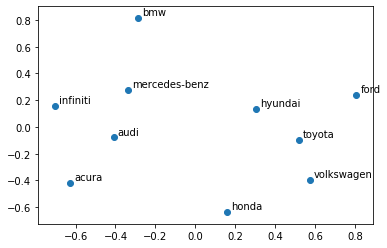

In [95]:
fig, ax = plt.subplots()
ax.scatter(mds_output['x'], mds_output['y'])
for brand in inverse_lift_brands.index.values:
    ax.text(mds_output.loc[brand, 'x']+0.02, mds_output.loc[brand, 'y']+0.02, brand)

##  <font color='red'>Task B: Insights</fonr>
TBD

## Task C
I went over 1500 words, picked and grouped words with intuition. 

Since professor said we don't have to do a sentiment analysis, I group positive and negative words together. For example, I grouped 'small' and 'large' into size attributes. 

Find 5 most frequently mentioned attributes.

In [96]:
word_frequency[:500]

car               3430
bmw               2551
wa                2300
like              2075
said              2054
one               2040
would             1965
audi              1911
ha                1733
get               1655
new               1508
think             1482
year              1348
even              1273
time              1188
good              1185
acura             1134
much              1132
well              1125
know              1070
really            1069
drive             1023
honda             1000
still              983
doe                983
could              978
price              973
make               973
go                 925
also               922
better             915
dealer             897
see                855
thing              847
look               833
want               824
people             816
say                815
way                796
've                777
back               756
3                  741
model              721
going      

In [97]:
attribute_dict = { 
    'performance': ['drive', 'engine', 'sport', 'driving', 'performance', 'power', 'spped', 
                    'fast', 'faster', 'sporty', 'horsepower', 'powerful'],
    
    'fuel_efficiency': ['mile', 'mileage', 'oil', 'diesel', 'mpg', 'gas', 'fuel'],
    
    'look': ['look', 'nice', 'looking', 'design', 'nicer', 'style', 'attractive', 'designed', 'looked'],
    
    'luxury': ['great', 'brand', 'luxury', 'best', 'premium'],
    
    'reliability': ['issue', 'problem', 'recall', 'trouble', 'concerned', 'suspension', 'reliable',
                   'service', 'warranty', 'durability', 'quality'],
    
    'price': ['money', 'msrp', 'price', 'sale', 'offer', 'discount', 'bargain', 'grand', 'expensive',
             'cheap', 'cheaper', 'incentive', 'worth'],
    
    'size': ['big', 'huge', 'large', 'size', 'weight', 'bigger', 'sticker', 'roof',
            'little', 'small', 'light', 'smaller', 'biggest'],

    'interior': ['seat', 'interior', 'leather', 'steering', 'inside', 'radio', 'noise', 'quiet'],

    'experience': ['experience', 'speciall', 'interesting', 'impressive', 'surprised', 'amazing', 
                   'fun', 'happy', 'enthusiast'],
    
    'safety': ['safety', 'life', 'safe']}

## Task C: Find top 5 attributes

In [98]:
def count_attribute(df, attribute_terms):
    return(np.sum(df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1 )))

top_attributes = pd.DataFrame(pd.Series(attribute_dict), columns=['attribute_terms'])
top_attributes['count'] = top_attributes['attribute_terms'].map(lambda x: count_attribute(df, x))

top_attributes.sort_values(by=['count'], ascending=False)[:5]

,attribute_terms,count
performance,"[drive, engine, sport, driving, performance, p...",2646
price,"[money, msrp, price, sale, offer, discount, ba...",2259
look,"[look, nice, looking, design, nicer, style, at...",1863
size,"[big, huge, large, size, weight, bigger, stick...",1716
luxury,"[great, brand, luxury, best, premium]",1654


## Task C: Which attributes are most strongly associated with which of the top 5 brands?

In [99]:
def lift_attribute_to_brands(attribute, attribute_dict, brand_list, df):
    '''
    attribute is a string
    
    attribute_dict is the dictionary whose keys are attibutes and values are words(attribute_terms).
    
    df is the processed dataframe contains processed comments 
    '''
    attribute_terms = attribute_dict[attribute]
    output = dict()
    for brand in brand_list.index.values:
        df_a = df[df['processed'].map(lambda x: len([term for term in attribute_terms if term in x])>=1)]
        N_a = df_a.shape[0] # count of comments w/ attribute
        N_b = sum(df['processed'].map(lambda x: brand in x)) # count of comments w/ brand
        N = df['processed'].shape[0]
        N_ab = sum(df_a['processed'].map(lambda x: brand in x)) # count of cooments w/ attribute and brand
        
        output[brand] = N*N_ab/(N_a*N_b)
        
    return(output)

In [100]:
brand_list = top10_brands[:5]

for attribute in top_attributes.index.values[:5]:
    print(attribute)
    output = lift_attribute_to_brands(attribute, attribute_dict, brand_list, df)
    output = pd.Series(output).sort_values(ascending=False)
    print(output)
    print('')

performance
audi        1.535607
bmw         1.508026
infiniti    1.471312
honda       1.410509
acura       1.366333
dtype: float64

fuel_efficiency
honda       1.641091
audi        1.424646
acura       1.356557
bmw         1.276385
infiniti    1.180158
dtype: float64

look
audi        1.629225
acura       1.597290
infiniti    1.591014
honda       1.579228
bmw         1.317249
dtype: float64

luxury
infiniti    2.130851
audi        1.908645
acura       1.858200
honda       1.835349
bmw         1.497805
dtype: float64

reliability
audi        1.778404
honda       1.560677
acura       1.527074
bmw         1.499618
infiniti    1.490724
dtype: float64



## <font color='red'>Task D</font>
 TBD 

## Task E: The most aspirational brand 
### You can play around with different words by changing the words in the list below.

We can also try bigram, trigram if possible.

In [101]:
aspiration_dict = { 'aspiration': ['want', 'like', 'best', 'love', 'wanted', 'dream'] }

In [102]:
brand_list = top10_brands

output = lift_attribute_to_brands('aspiration', aspiration_dict, brand_list, df)
output = pd.Series(output).sort_values(ascending=False)
print(output)
print('')

mercedes-benz    1.641880
infiniti         1.542057
audi             1.514346
toyota           1.492916
honda            1.468704
ford             1.445877
acura            1.411781
volkswagen       1.384729
bmw              1.372234
hyundai          1.353288
dtype: float64

